# Background

In this notebook, I simulate a set of 200 diploid individuals under an invasion-like demographic scenario and perform Ne inference using the developed approach. 

In [1]:
params = {
    "sample_size": 200,
    "Ne": 5_000,
    "L": 1e8,
    "num_chr": 10,
    "recombination_rate": 1e-8,
    "mutation_rate": 1e-8,
    "seed": 1234,
    # Invasion-like demography
    "time_of_invasion" : 50,
    "founders" : 100,
    "Ne_modern" : 10_000,
    "Ne_anc" : 15_000
}

# Data simulation
## Demographic scenario

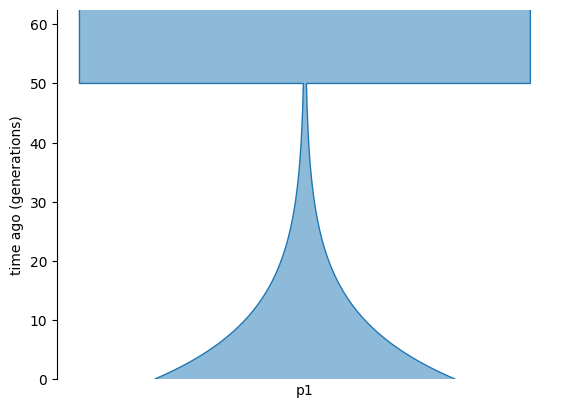

In [2]:
import msprime, demesdraw
import demesdraw
import matplotlib.pyplot as plt
import numpy as np
demography = msprime.Demography()
alpha = (np.log(params['Ne_modern']) - np.log(params['founders'])) / params['time_of_invasion']
demography = msprime.Demography()
demography.add_population(name="p1", initial_size=params['Ne_modern'], growth_rate=alpha)
demography.add_population_parameters_change(
    population='p1',
    initial_size=params['Ne_anc'],
    time=params['time_of_invasion'],
    growth_rate=0.0
)
graph = msprime.Demography.to_demes(demography)
fig, ax = plt.subplots()  # use plt.rcParams["figure.figsize"]
demesdraw.tubes(graph, ax=ax, seed=1)
plt.show()

## Geneology simulation

In [3]:
replicates = msprime.sim_ancestry(
    samples=params["sample_size"],
    demography=demography,
    sequence_length=params["L"],
    num_replicates=params["num_chr"],
    recombination_rate=params["recombination_rate"],
    random_seed=params["seed"],
)
replicates = [
    msprime.sim_mutations(ts, rate=params["mutation_rate"], random_seed=params["seed"])
    for ts in replicates
]

## LD preprocessing

The developed approach requires binned linkage-disequilibrium data (i.e., the expected $E[X_iX_jY_iY_j]$ for a pair of loci $u$ units apart). The compiled executable `ldbucket` takes an indexed BCF or VCF.gz as input.

Binaries for `ldbucket` are available in the [GitHub repository release](https://github.com/currocam/invasion-Ne-extras/releases) for different operating systems. Alternatively, compile it yourself with `cargo build —release` if you have the Rust toolchain available. 


In [4]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../src")))

In [15]:
import pandas as pd
def process(ts, name, recombination_rate):
    # Much faster than current python implementation from tskit ...
    import subprocess
    ts.dump(f"{name}.trees")
    subprocess.run([f"tskit vcf --allow-position-zero --contig-id {name} {name}.trees | bcftools view -O b > {name}.bcf"],shell=True)
    subprocess.run([f"bcftools index {name}.bcf"],shell=True)
    subprocess.run([f"./ldbucket {name}.bcf --recombination-rate {recombination_rate} > {name}.csv"],shell=True)
    df = pd.read_csv(f"{name}.csv")
    subprocess.run([f"rm {name}.trees {name}.bcf* {name}.csv"],shell=True)
    return df

In [16]:
datasets = [
    process(
        mts, name=f"seed_{i}", recombination_rate=params["recombination_rate"]
    )
    for i, mts in enumerate(replicates)
]

In [19]:
pd.to_pickle(datasets, "datasets_exp.pkl")

We re-arrange the data into a DataFrame and a numpy matrix. 

In [20]:
import pandas as pd

df = pd.concat(datasets)
df.head()

,contig_name,bin_index,left_bin,right_bin,mean,var,N
0,seed_0,0,0.005,0.010,0.033898,0.002771,21726810
1,seed_0,1,0.010,0.015,0.022356,0.001417,21611027
2,seed_0,2,0.015,0.020,0.015158,0.000777,21540052
3,seed_0,3,0.020,0.025,0.010332,0.000452,21377450
4,seed_0,4,0.025,0.030,0.007202,0.000290,21257016


In [21]:
import numpy as np

observed_data = np.array([x["mean"] for x in datasets])
observed_data.shape

(10, 19)

# Model


Next, we define the (Bayesian) model assuming a constant $N_e$ demographic scenario. We will use a pseudo-likelihood by assuming the mean $\mathbb E[X_iX_jY_iY_j]$ per chromosome across every bin follows a normal distribution and estimate the variance from the data. 


In [22]:
import arviz as az
import pymc as pm
import pytensor.tensor as pt
from constant_population import predict_ld

print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-darkgrid")

Running on PyMC v5.25.1


In [64]:
coords = {
    "contigs": df.contig_name.unique().astype(str),
    "bins": df.bin_index.unique().astype(int),
    "left_bins": df.left_bin.unique().astype(float),
    "right_bins": df.right_bin.unique().astype(float),
    "right_bins": df.right_bin.unique().astype(float),
}
coords["midpoints"] = (coords["left_bins"] + coords["right_bins"]) / 2
nbins = len(coords["bins"])

### Numerical integration

In order to derive expectations for more complicated models, we rely on numerical integration using Gaussian-Legendre rules. The granularity (how many points to use) is a trade-off between accuracy and efficiency. Default values are conservative. We suggest you try with small values (as small as n=10) and increase them if necessary. 

In [65]:
from exponential_constant_population import predict_ld_builder
predict_ld = predict_ld_builder(
    u_i=coords['left_bins'], u_j = coords['right_bins'], 
    granularity_time = 10, granularity_bins = 10
)

In [67]:
with pm.Model(coords=coords) as model:
    # Set up prior on the population size so around
    # 90% of the mass probability is between 100 and 30000
    Ne1 = pm.Lognormal("Ne1", mu=9.3, sigma=0.8)
    # So 95% mass is within \pm 1000 of the true value
    Ne2 = pm.Lognormal("Ne2", mu=9.61, sigma=0.034)
    # So 95% is within 0 and 100
    t0 = pm.Lognormal("t0", mu=3.61, sigma=0.608)
    # So logfold of change is within -2 and +2 with 95% mass probability
    alpha = pm.Normal("alpha", mu=0, sigma=1 / t0)
    # Effective number of founders
    pm.Deterministic("founders", Ne1 * pt.exp(-alpha * t0))
    # For visualization later...
    pm.Deterministic(
        "Ne_traj", 
        pt.switch(np.arange(100) < t0, Ne1 * pt.exp(-alpha * np.arange(100)), Ne2)
    )
    # Compute the expected vector of LD per bin
    mu = pm.Deterministic(
        "LD_mu", predict_ld(Ne1, Ne2, alpha, t0, params["sample_size"]), dims="bins"
    )
    # Use the data to set up the prior on the covariance
    # Later code assumes `LD_obs` is defined
    obs = pm.Data("LD_obs", observed_data, dims=("contigs", "bins"))
    sigma2 = pm.Exponential("LD_sigma2", obs.var(axis=0), dims="bins")
    cov = pt.diag(sigma2)
    # Assume each bin follows a Normal distribution
    likelihood = pm.MvNormal("LD", mu, cov, observed=obs, dims=("contigs", "bins"))

## Sampling from the approximate posterior

In [68]:
with model:
    trace = pm.sample(random_seed=params["seed"])
    # We also found following values work better when having divergences
    # target_accept=0.90, random_seed=seed, init = "advi+adapt_diag"
az.summary(trace, var_names=["~LD_sigma2", "~LD_mu", "~Ne_traj"])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne1, Ne2, t0, alpha, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.086,0.003,0.080,0.091,0.000,0.000,1519.0,2147.0,1.0
Ne1,8576.483,376.129,7861.928,9279.989,9.444,5.907,1579.0,2209.0,1.0
Ne2,14933.714,505.962,14005.856,15883.054,6.755,8.917,5548.0,2631.0,1.0
t0,52.742,1.134,50.475,54.802,0.029,0.019,1576.0,2111.0,1.0
founders,94.298,2.299,89.926,98.595,0.036,0.035,4089.0,3445.0,1.0


# Diagnosis

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'Ne1'}>, <Axes: title={'center': 'Ne1'}>],
       [<Axes: title={'center': 'Ne2'}>, <Axes: title={'center': 'Ne2'}>],
       [<Axes: title={'center': 't0'}>, <Axes: title={'center': 't0'}>],
       [<Axes: title={'center': 'founders'}>,
        <Axes: title={'center': 'founders'}>]], dtype=object)

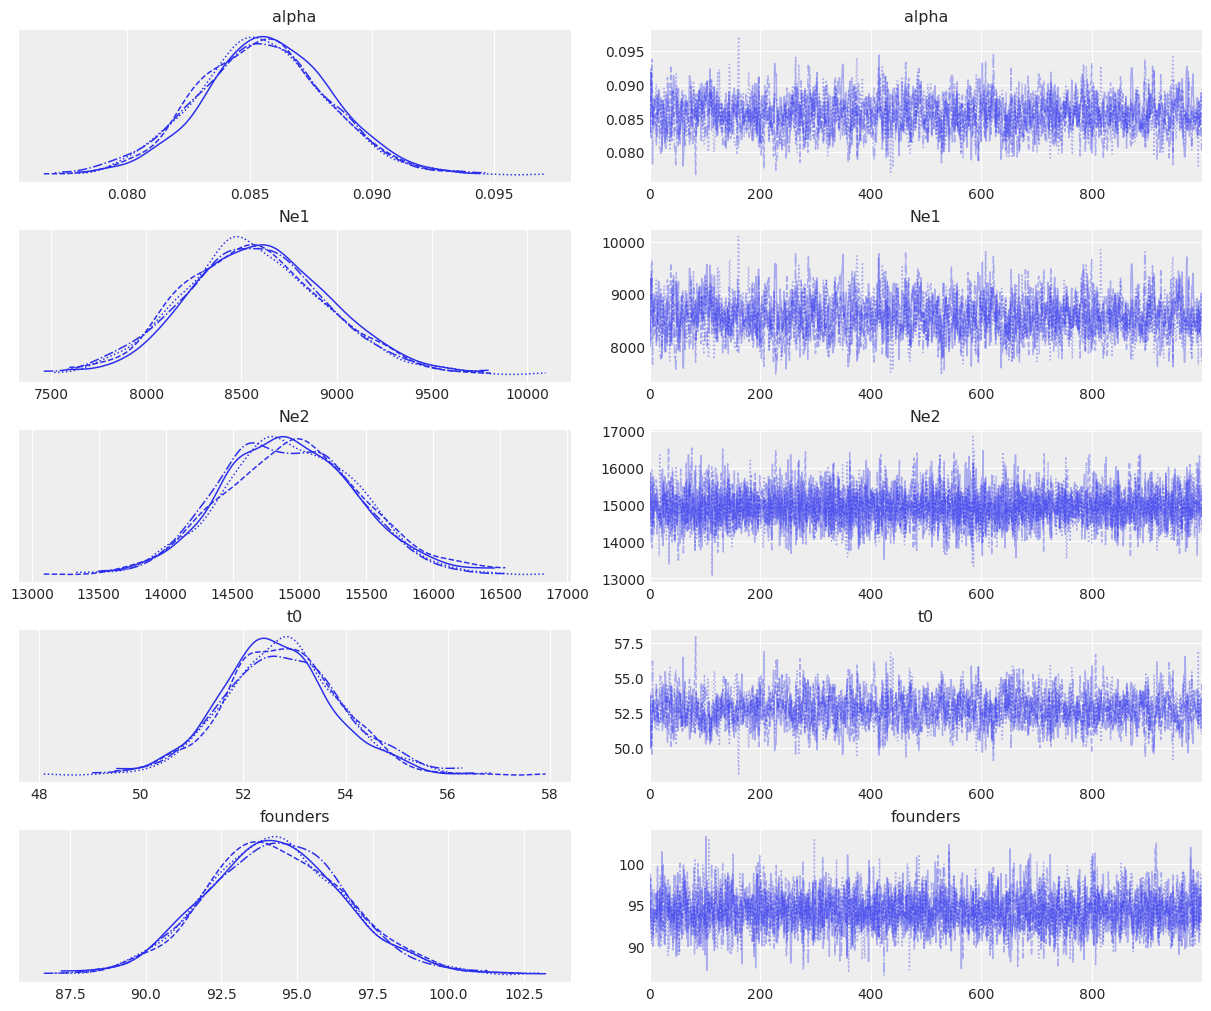

In [69]:
az.plot_trace(trace, var_names=["~LD_sigma2", "~LD_mu", "~Ne_traj"])

In [76]:
alpha_true = (np.log(params['Ne_modern']) - np.log(params['founders'])) / params['time_of_invasion']
ground_truth = np.where(
    np.arange(100) < params['time_of_invasion'],
    params['Ne_modern'] * np.exp(-alpha_true * np.arange(100)),
    params['Ne_anc']
)

In [ ]:
log(Ne_f) = Ne1 * exp(-alpha*times)

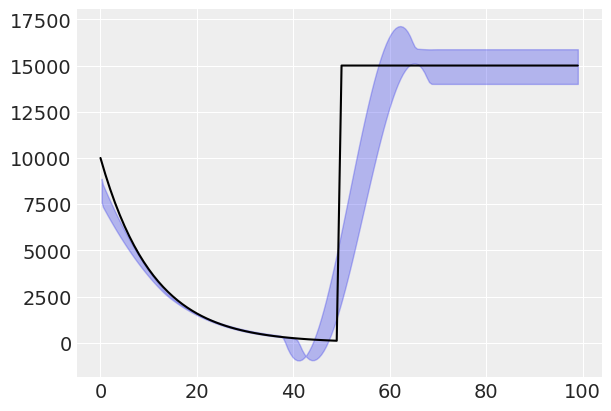

In [79]:
hdi_Ne = az.hdi(
    trace.posterior["Ne_traj"],
    input_core_dims=[["chain", "draw"]],
)
fig, ax = plt.subplots(figsize=(6, 4))
az.plot_hdi(
    np.arange(100),
    hdi_data=hdi_Ne,
    ax=ax,
    color="C0",
    fill_kwargs={"alpha": 0.3},
)
ax.plot(np.arange(100),ground_truth, color="black")

## Posterior predictive distribution

In [80]:
with model.copy():
    LD_pp = pm.sample_posterior_predictive(trace)

Sampling: [LD]


Output()

Text(0, 0.5, '$E[X_i X_j Y_i Y_j]$')

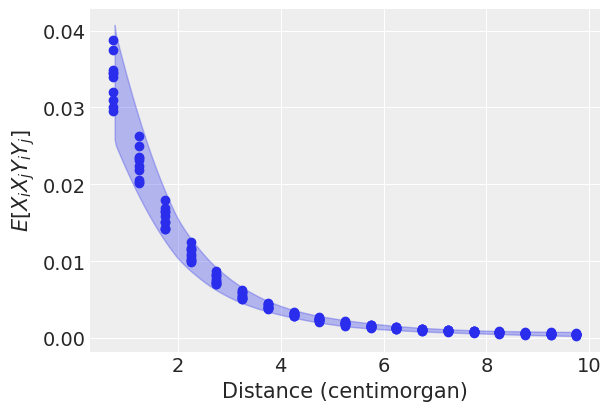

In [81]:
fig, ax = plt.subplots(figsize=(6, 4))
x = coords["midpoints"] * 100
hdi_data = az.hdi(
    LD_pp.posterior_predictive["LD"],
    input_core_dims=[["chain", "draw", "contigs"]],
)
az.plot_hdi(
    x,
    hdi_data=hdi_data,
    ax=ax,
    color="C0",
    fill_kwargs={"alpha": 0.3},
)
x_rep = np.repeat(x[None, :], params["num_chr"], axis=0)
ax.scatter(
    x_rep.flatten(),
    LD_pp.observed_data["LD"].values.flatten(),
)
ax.set_xlabel("Distance (centimorgan)")
ax.set_ylabel(r"$E[X_i X_j Y_i Y_j]$")

## Model evaluation using leave-one-out

In [82]:
with model:
    pm.compute_log_likelihood(trace)
loo = az.loo(trace)
loo

Output()

/Users/currocam/Documents/Dev/invasion-Ne-extras/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1283.66    17.93
p_loo       25.50        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)        8   80.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    2   20.0%

Often, the diagnosis reports that the results are not reliable. In those cases, we can compute the ELPD-LOO exactly (although the values might not change).

In [83]:
from sampling_wrapper import PyMCModelWrapper

pymc_wrapper = PyMCModelWrapper(model=model, idata_orig=trace)
loo_relooed = az.reloo(pymc_wrapper, loo_orig=loo)
loo_relooed

/Users/currocam/Documents/Dev/invasion-Ne-extras/.venv/lib/python3.12/site-packages/arviz/stats/stats_refitting.py:100: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne1, Ne2, t0, alpha, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne1, Ne2, t0, alpha, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1282.43    18.91
p_loo       26.73        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       10  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

For comparison, we will also fit a constant Ne model. 

In [87]:
from constant_population import predict_ld as predict_ld_constant
with pm.Model(coords=coords) as model_constant:
    # Set up prior on the population size so around
    # 90% of the mass probability is between 100 and 30000
    Ne = pm.Lognormal("Ne", mu=9.3, sigma=0.8)
    # Compute the expected vector of LD per bin
    u_i = coords["left_bins"]
    u_j = coords["right_bins"]
    mu = pm.Deterministic(
        "LD_mu", predict_ld_constant(u_i, u_j, Ne, params["sample_size"]), dims="bins"
    )
    # Use the data to set up the prior on the covariance
    # Later code assumes `LD_obs` is defined
    obs = pm.Data("LD_obs", observed_data, dims=("contigs", "bins"))
    sigma2 = pm.Exponential("LD_sigma2", obs.var(axis=0), dims="bins")
    cov = pt.diag(sigma2)
    # Assume each bin follows a Normal distribution
    likelihood = pm.MvNormal("LD", mu, cov, observed=obs, dims=("contigs", "bins"))
    trace_constant = pm.sample(random_seed=params["seed"])
    pm.compute_log_likelihood(trace_constant)
loo_constant = az.loo(trace_constant)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Output()

/Users/currocam/Documents/Dev/invasion-Ne-extras/.venv/lib/python3.12/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [89]:
loo_relooed_constant = az.reloo(
    PyMCModelWrapper(model=model_constant, idata_orig=trace_constant),
    loo_orig=loo_constant
)
loo_relooed_constant

/Users/currocam/Documents/Dev/invasion-Ne-extras/.venv/lib/python3.12/site-packages/arviz/stats/stats_refitting.py:100: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ne, LD_sigma2]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Computed from 4000 posterior samples and 10 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  1046.04     8.43
p_loo        7.22        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)       10  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

<Axes: xlabel='elpd_loo (log)', ylabel='ranked models'>

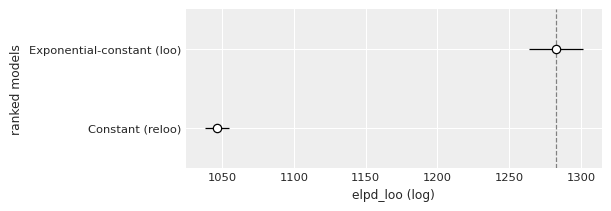

In [90]:
loo_df = az.compare(
    {"Exponential-constant (loo)": loo_relooed, "Constant (reloo)": loo_relooed_constant}
)
az.plot_compare(loo_df, title=False)

# Model calibration
In order to obtain tractable inference, we have to approximate the model. Because of this, resulting inference is biased. We can, however, assess that the model is in fact well-defined by assesing whether it has proper nomimal coverage in the *small* world where assumptions are met. 

In [91]:
from arviz_plots import plot_ecdf_pit, style
import numpy as np
import simuk
style.use("arviz-variat")

In [92]:
from arviz_plots import plot_ecdf_pit
sbc = simuk.SBC(model, num_simulations=100, sample_kwargs={'draws': 1000, 'tune': 1000})

In [93]:
sbc.run_simulations()

100%|██████████████████████████████████████████████████████████████████████████████████| 100/100 [25:53<00:00, 15.54s/it]


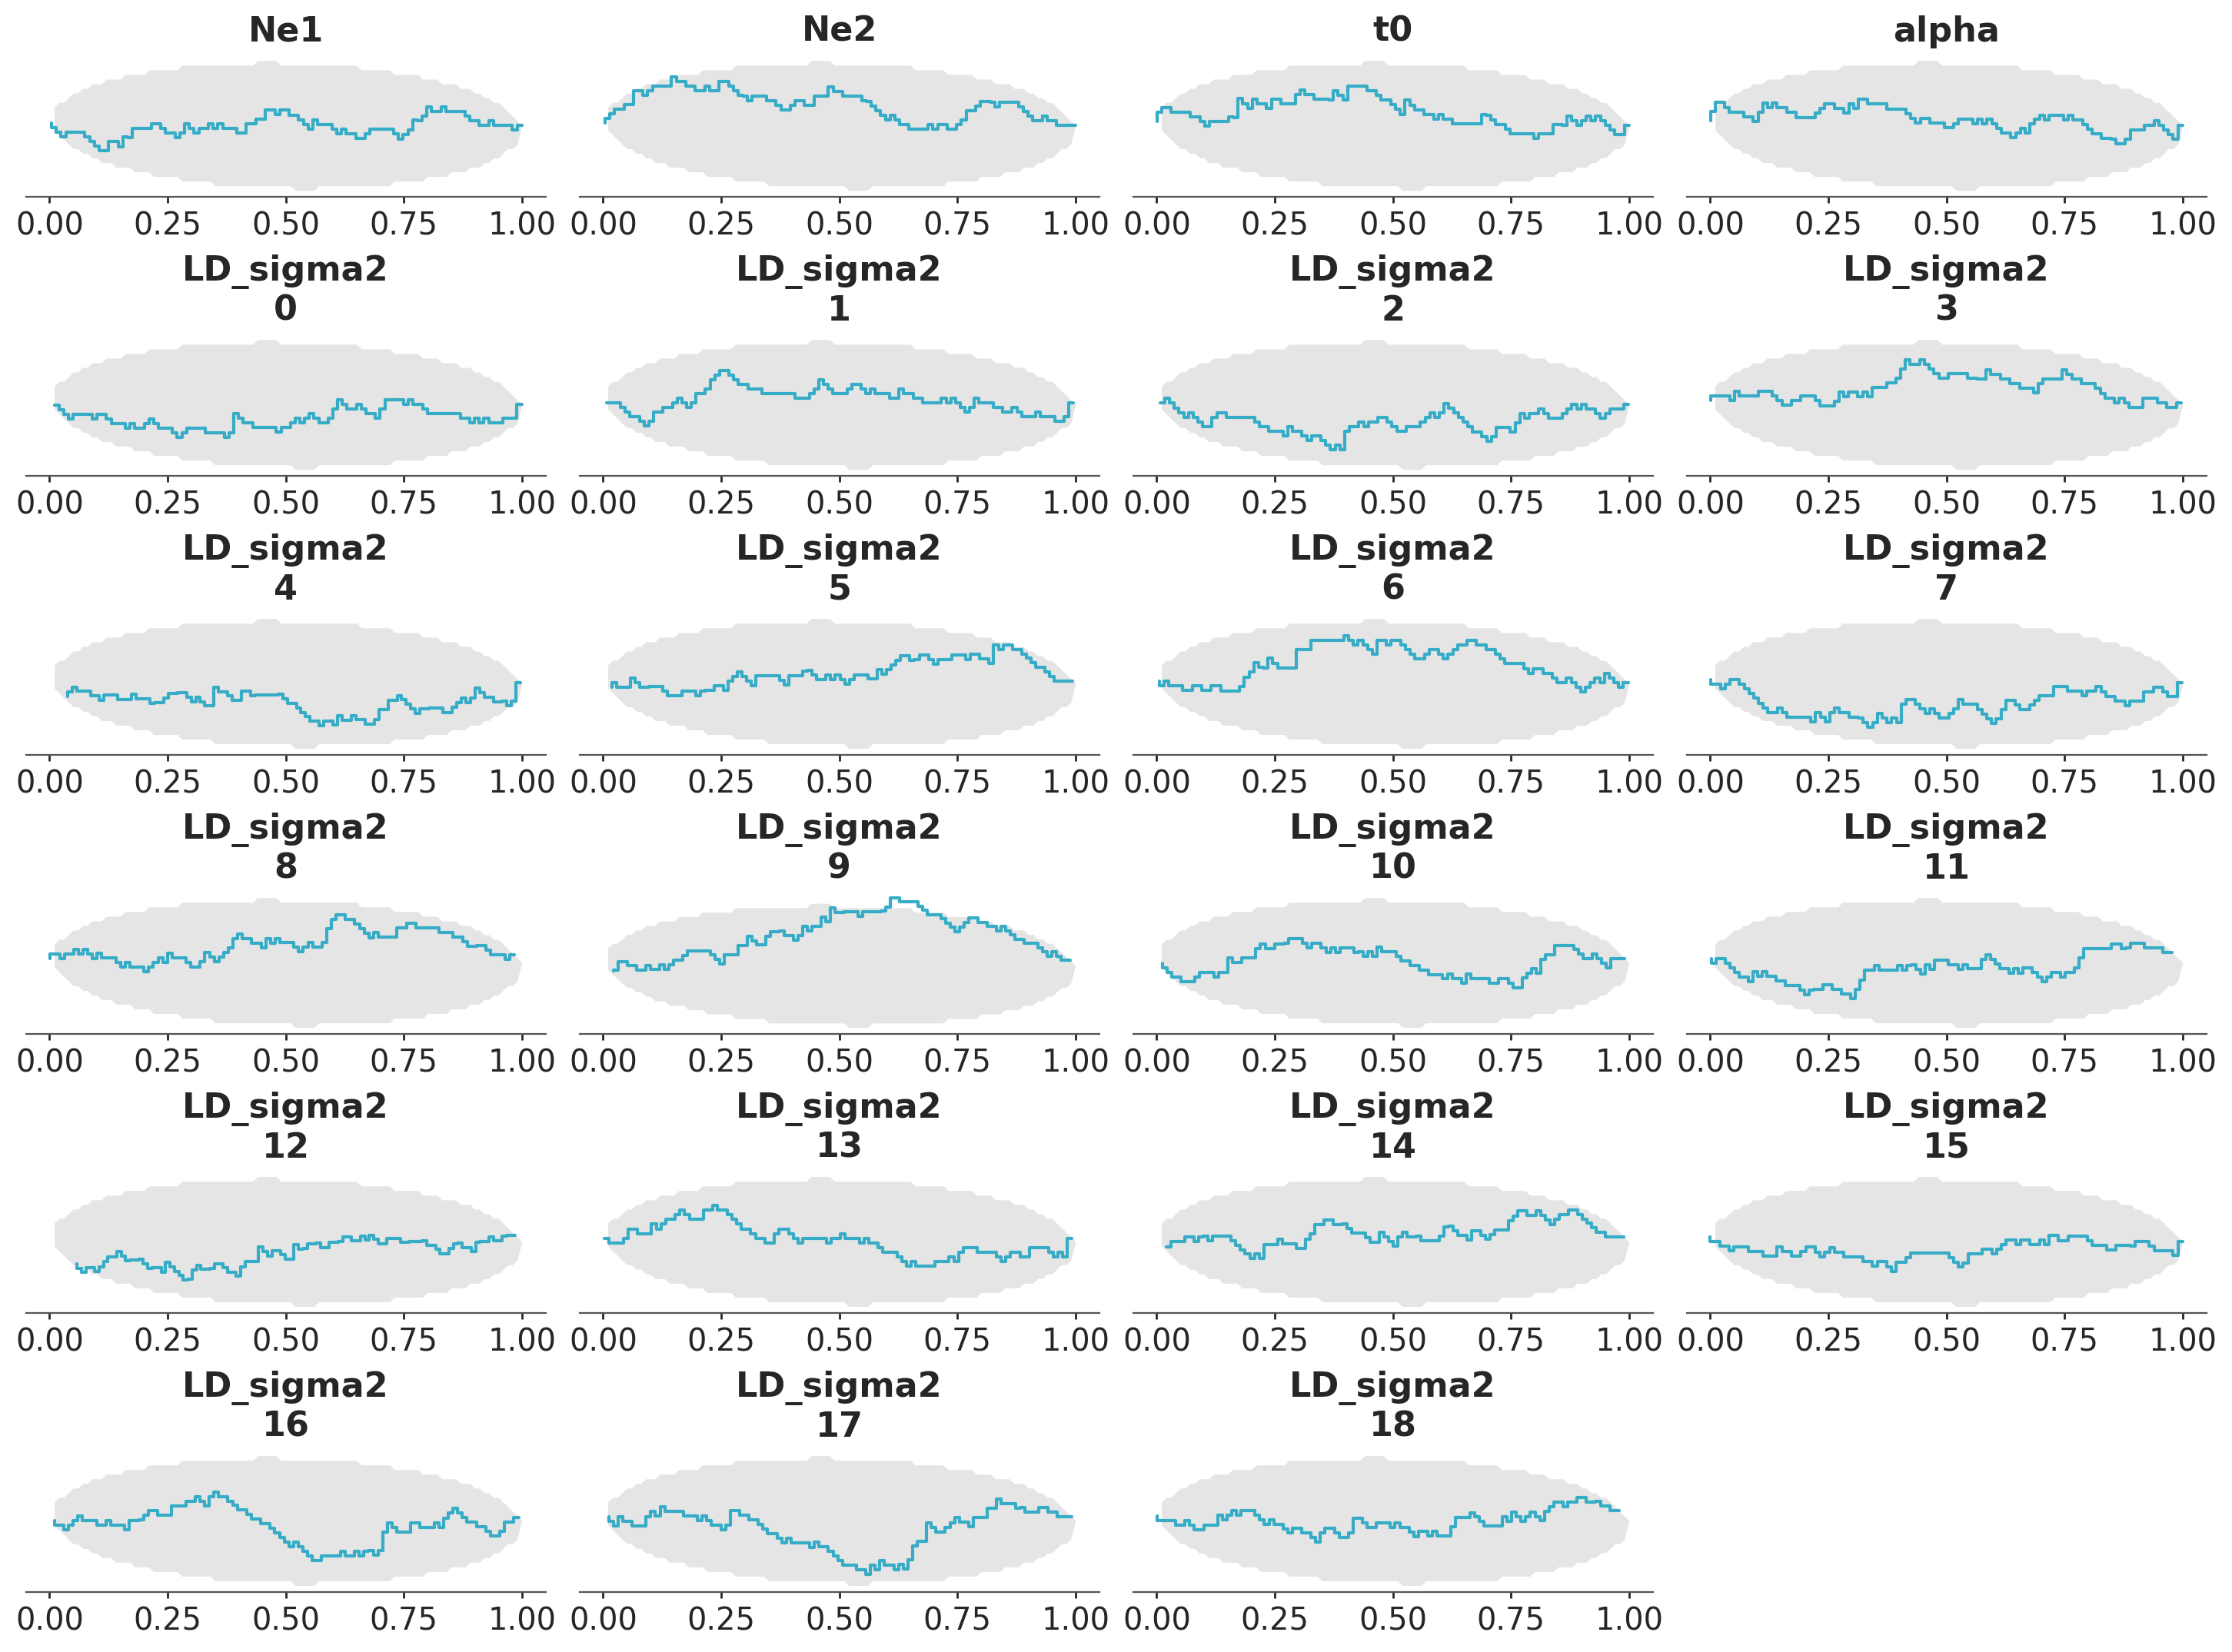

In [94]:
plot_ecdf_pit(sbc.simulations,
            visuals={"xlabel":False},
);